# MODULES


In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn import datasets
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm

from scipy.stats import chi2
from scipy.stats import chisquare


___

# INFERENCE
## Overview

We can infer the value of the **population parameter** based on the sample statistics. Which parameter represents the population the best depends on the probability distribution.

_Fisher & Chi-Squared tests measure the proportion of samples in different categories._

<br></br>
![png](../../img/stat_tests/stat_tests_inference.png)


___

# One-sample t-test
## Test Parameters

_Note: The one-sample t-test is a direct application of the CLT with an unknown population variance._

The null hypothesis $H_0$ states that the population mean is equal to a specified value $\mu_0$. 

Our test statistic is 
$t={\frac {{\bar {X}}-\mu_0 }{{\widehat {\sigma }}/{\sqrt {n}}}}$
where $\bar {X}$ is the sample mean, $\widehat {\sigma}^2$ its unbiased variance and $n$ its size.

Under the null hypothesis, the test statistic follows a $t$-distribution with $n-1$ degrees of freedom. 


## Example - Iris Versicolor

Going back to iris species, let's perform a t-test to check if the mean of the versicolor species can plausibly be outside of its 95% confidence interval; by construction, we know that it is highly unlikely, which should be reflected in the results of our test.


### Assumptions

We saw in previous chapters that the sample data is roughly normal. Even if it wasn't the case, the sample size is large enough that the assumptions of normality required by the t-tests are met.


### Hypothesis

The 95% confidence interval for the mean of the versicolor species is \[4.128, 4.392\]. 
We will perform a t-test with the following parameters:
+ our null hypothesis states that the population mean $\mu = 4.4cm$, just outside of it. 
+ our alternate hypothesis states that $\mu \neq 4.4cm$ (two-sided t-test).
+ we set the signifance level $\alpha = 0.05$.

We will reject the null hypothesis if the p-value is below $\alpha$. 


### Manual t-test

We start by calculating the t-test manually, using the CLT for populations of unknown variance. The results show that the p-value is below alpha, so we reject the null hypothesis: we conclude that the population mean is different from 4.4cm.


test stat: -2.107; two-sided p-value: 0.040


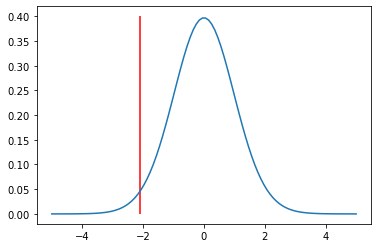

In [72]:
# what follows give the same results as stats.ttest_1samp(sample, popmean)

# load & format iris dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['species'] = [iris.target_names[i] for i in iris.target]

# petal lenghts of versicolors
sample = iris_df.loc[iris_df['species'] == 'versicolor', 'petal length (cm)'].to_numpy()

# the 95% CI for the mean of versicolor is [4.128, 4.26, 4.392]. Let's try with a value outside of this CI.
popmean = 4.4

# sample values
sample_size = len(sample)
sample_mean = np.mean(sample)
sample_var = np.var(sample, ddof=1) # ddof=1 for unbiased variance
sample_se = np.sqrt(sample_var / sample_size)

# test statistic
sample_t = (sample_mean - popmean) / sample_se

# dist of test statistic under H0
null_sampling_dist = stats.t(df=sample_size - 1)

# likelihood of having a value at least as extreme (two-sided so 2*)
sample_p = 2 * null_sampling_dist.cdf(sample_t)

# return the test statistic and p-value
print('test stat: {:0.3f}; two-sided p-value: {:0.3f}'.format(sample_t, sample_p))

# show dist of test statistic under H0 vs sample test statistic
x = np.linspace(-5, 5, 100)
_ = plt.plot(x, null_sampling_dist.pdf(x))
_ = plt.vlines(x=sample_t, ymin=0, ymax=0.4, color='r')


### Built-in t-test

We can use the built-in function to reach the exact same results:


In [21]:
# stats t-test
sample_t, sample_p = stats.ttest_1samp(sample, popmean)
print('test stat: {:0.3f}; two-sided p-value: {:0.3f}'.format(sample_t, sample_p))


test stat: -2.107; two-sided p-value: 0.040


### Effect Size

We can now quantify the normalized effect size we wanted to test, using the formula for cohen's d; The results show that the effect size is fairly small.


In [73]:
# effect size (cohen's d)
sample_diff = sample_mean - popmean
sample_cohen_d = sample_diff / np.sqrt(sample_var)

print('difference in mean: {:.3f}; cohen\'s d: {:.3f}'.format(sample_diff, sample_cohen_d))


difference in mean: -0.140; cohen's d: -0.298


### Statistical Power

The t-test is statistically significant, which means there are no risks of Type II errors (incorrectly failing to reject a null hypothesis). But both the effect size and sample size are quite small, so its statistical power is quite small too, as illustrated by the calculation below.



In [74]:
# calculate power
test_power = sm.stats.tt_solve_power(effect_size=sample_cohen_d, nobs=sample_size, alpha=0.05)
print('power of the t-test (alpha=0.05): {:0.0%}'.format(test_power))


power of the t-test (alpha=0.05): 54%


### Sample Size vs Effect Size

Let's assume that we wanted to design the experiment before collecting any data. Calculating the relevant normalized effect size can prove difficult: we used the sample mean and variance to calculate it in our example, which would not be available before running the experiment.

We can use the litterature and previous experiments to help us figure out a meaningful effect size. Let's assume for instance that we already collected sample data for the iris species virginica, that we know its distribution is close to versicolor, and that we want to detect a difference of means of at least 2.5mm.


In [53]:
# petal lenghts of virginica
virg_sample = iris_df.loc[iris_df['species'] == 'virginica', 'petal length (cm)'].to_numpy()

# sample values
virg_sample_var = np.var(virg_sample, ddof=1) # ddof=1 for unbiased variance

# normalized effect size
diff_of_mean = 0.25
virg_cohen_d = diff_of_mean / np.sqrt(virg_sample_var)

print('effect size for virginica: {:.3f}'.format(virg_cohen_d))


effect size for virginica: 0.453


We can now calculate the sample size required to capture such variations (medium effect size):


In [76]:
# calculate required sample size (ceil because the formula returns the minimum sample size; we take the closest integer that is higher)
test_size = sm.stats.tt_solve_power(effect_size=virg_cohen_d, alpha=0.05, power=0.8)
print('required sample size for the t-test (alpha=0.05, power=0.8): {}'.format(np.ceil(test_size)))


required sample size for the t-test (alpha=0.05, power=0.8): 41.0
